In [12]:
# import os
# import pandas as pd

# # Укажите путь к папке с изображениями
# image_folder = "./dataset/images"

# # Собираем данные для CSV
# data = []
# for filename in os.listdir(image_folder):
#     if filename.lower().endswith(('.png', '.jpg', '.jpeg')):  # проверяем формат
#         # Извлекаем имя класса из названия файла (часть до первого символа '_')
#         if (filename.split('-')[0] == 't'):
#             class_name = 0
        
#         else:
#             class_name = 1
#         # class_name = 0 if filename.split('-')[0] == 't' else 1
        
#         # Добавляем запись
#         data.append({
#             "image_name": filename,
#             "class": class_name
#         })

# # Создаем DataFrame и сохраняем в CSV
# df = pd.DataFrame(data)
# df.to_csv("labels.csv", index=False)

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import albumentations as A
import cv2

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import albumentations as A
import os
from tqdm import tqdm

In [33]:
class DualTaskModel(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        
        # Энкодер с явным указанием выходного разрешения
        self.encoder = timm.create_model(
            'efficientnet_b0',
            pretrained=True,
            features_only=True,
            out_indices=(4,)  # Фичи с последнего слоя (8x8 для входа 256x256)
        )
        
        # Декодер с точной апсемплирующей структурой
        self.decoder = nn.Sequential(
            # Блок 1: 8x8 -> 16x16
            nn.ConvTranspose2d(320, 256, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            
            # Блок 2: 16x16 -> 32x32
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            # Блок 3: 32x32 -> 64x64
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            # Блок 4: 64x64 -> 128x128
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            
            # Блок 5: 128x128 -> 256x256
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            
            # Финал
            nn.Conv2d(16, 1, kernel_size=1)
        )

        # Классификационная головка
        self.cls_head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(320, num_classes)
        )

    def forward(self, x):
        # Энкодер: [B,3,256,256] -> [B,320,8,8]
        features = self.encoder(x)[0]
        
        # Декодер: [B,320,8,8] -> [B,1,256,256]
        seg_output = self.decoder(features)
        
        # Классификация
        cls_output = self.cls_head(features)
        
        return seg_output, cls_output

In [34]:
class ObjectDataset(Dataset):
  def __init__(self, root_dir, split='train', img_size=256):
    self.root_dir = root_dir
    self.img_size = img_size
    self.labels_df = pd.read_csv(os.path.join(root_dir, 'labels.csv'))
    
    # Разделение данных
    split_idx = int(0.8 * len(self.labels_df))
    if split == 'train':
      self.data = self.labels_df.iloc[:split_idx]
    else:
      self.data = self.labels_df.iloc[split_idx:]
    
    # Аугментации
    self.transform = A.Compose([
      A.Resize(img_size, img_size),
      A.HorizontalFlip(p=0.5),
      A.RandomBrightnessContrast(p=0.3),
      A.GaussianBlur(p=0.1),
      A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

  def __len__(self):
      return len(self.data)

  def __getitem__(self, idx):
    row = self.data.iloc[idx]
    
    # Загрузка изображения
    img_path = os.path.join(self.root_dir, 'images', row['image_name'])
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Загрузка маски
    mask_path = os.path.join(self.root_dir, 'masks', row['image_name'].replace('.jpg', '.png'))
    mask = cv2.imread(mask_path, 0)
    
    # Применение аугментаций
    transformed = self.transform(image=image, mask=mask)
    image = transformed['image']
    mask = transformed['mask']
    
    # Преобразование в тензоры
    image = torch.tensor(image).permute(2, 0, 1).float()
    mask = torch.tensor(mask).unsqueeze(0).float()
    label = torch.tensor(row['class']).long()
    
    return image, mask, label

In [35]:
def train_model():
  # Параметры
  BATCH_SIZE = 8
  EPOCHS = 20
  LR = 1e-4
  
  # Датасеты
  train_dataset = ObjectDataset('dataset', 'train')
  val_dataset = ObjectDataset('dataset', 'val')
  
  train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
  
  # Модель и оптимизатор
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model = DualTaskModel(num_classes=3).to(device)
  optimizer = optim.Adam(model.parameters(), lr=LR)
  
  # Функции потерь
  seg_criterion = nn.BCEWithLogitsLoss()
  cls_criterion = nn.CrossEntropyLoss()
  
  # История обучения
  history = {'train_loss': [], 'val_loss': [], 'cls_acc': []}
  
  for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    
    # Обучение
    for images, masks, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{EPOCHS}'):
      images = images.to(device)
      masks = masks.to(device)
      labels = labels.to(device)
      
      optimizer.zero_grad()
      
      seg_out, cls_out = model(images)
      loss_seg = seg_criterion(seg_out, masks)
      loss_cls = cls_criterion(cls_out, labels)
      loss = 0.7*loss_seg + 0.3*loss_cls
      
      loss.backward()
      optimizer.step()
      
      train_loss += loss.item()
    
    # Валидация
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
      for images, masks, labels in val_loader:
        images = images.to(device)
        masks = masks.to(device)
        labels = labels.to(device)
        
        seg_out, cls_out = model(images)
        loss_seg = seg_criterion(seg_out, masks)
        loss_cls = cls_criterion(cls_out, labels)
        loss = 0.7*loss_seg + 0.3*loss_cls
        
        val_loss += loss.item()
        _, predicted = torch.max(cls_out.data, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    
    # Сохранение метрик
    history['train_loss'].append(train_loss/len(train_loader))
    history['val_loss'].append(val_loss/len(val_loader))
    history['cls_acc'].append(100*correct/total)
    
    print(f"Epoch {epoch+1}: "
      f"Train Loss: {history['train_loss'][-1]:.4f}, "
      f"Val Loss: {history['val_loss'][-1]:.4f}, "
      f"Accuracy: {history['cls_acc'][-1]:.2f}%")
  
  # Графики обучения
  plt.figure(figsize=(12, 4))
  plt.subplot(121)
  plt.plot(history['train_loss'], label='Train Loss')
  plt.plot(history['val_loss'], label='Val Loss')
  plt.legend()
  
  plt.subplot(122)
  plt.plot(history['cls_acc'], label='Accuracy')
  plt.legend()
  plt.show()
  
  return model

In [36]:
def visualize_predictions(model, device, num_samples=3):
    dataset = ObjectDataset('dataset')
    model.eval()
    
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        image, true_mask, true_label = dataset[i]
        
        with torch.no_grad():
            seg_pred, cls_pred = model(image.unsqueeze(0).to(device))
        
        # Постобработка
        pred_mask = (torch.sigmoid(seg_pred) > 0.5).cpu().squeeze()
        pred_label = torch.argmax(cls_pred).item()
        
        # Визуализация
        plt.subplot(3, 3, i*3+1)
        plt.imshow(image.permute(1, 2, 0).numpy() * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406])
        plt.title(f"Original Image\nTrue Class: {true_label}")
        plt.axis('off')
        
        plt.subplot(3, 3, i*3+2)
        plt.imshow(true_mask.squeeze(), cmap='gray')
        plt.title("True Mask")
        plt.axis('off')
        
        plt.subplot(3, 3, i*3+3)
        plt.imshow(pred_mask, cmap='gray')
        plt.title(f"Predicted Mask\nPred Class: {pred_label}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

Using device: cpu


Unexpected keys (bn2.bias, bn2.num_batches_tracked, bn2.running_mean, bn2.running_var, bn2.weight, classifier.bias, classifier.weight, conv_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.
Epoch 1/20: 100%|██████████| 4/4 [00:03<00:00,  1.03it/s]


Epoch 1: Train Loss: 9.5360, Val Loss: 4.8186, Accuracy: 14.29%


Epoch 2/20: 100%|██████████| 4/4 [00:03<00:00,  1.03it/s]


Epoch 2: Train Loss: 6.0764, Val Loss: 5.0786, Accuracy: 42.86%


Epoch 3/20: 100%|██████████| 4/4 [00:03<00:00,  1.01it/s]


Epoch 3: Train Loss: 1.0788, Val Loss: 4.5600, Accuracy: 0.00%


Epoch 4/20: 100%|██████████| 4/4 [00:03<00:00,  1.02it/s]


Epoch 4: Train Loss: -4.7400, Val Loss: 1.8729, Accuracy: 0.00%


Epoch 5/20: 100%|██████████| 4/4 [00:03<00:00,  1.03it/s]


Epoch 5: Train Loss: -9.9881, Val Loss: -5.2318, Accuracy: 28.57%


Epoch 6/20: 100%|██████████| 4/4 [00:03<00:00,  1.03it/s]


Epoch 6: Train Loss: -15.3968, Val Loss: -12.5953, Accuracy: 57.14%


Epoch 7/20: 100%|██████████| 4/4 [00:03<00:00,  1.04it/s]


Epoch 7: Train Loss: -20.1301, Val Loss: -28.2721, Accuracy: 100.00%


Epoch 8/20: 100%|██████████| 4/4 [00:03<00:00,  1.03it/s]


Epoch 8: Train Loss: -24.6665, Val Loss: -35.8921, Accuracy: 100.00%


Epoch 9/20: 100%|██████████| 4/4 [00:03<00:00,  1.04it/s]


Epoch 9: Train Loss: -28.5114, Val Loss: -43.2784, Accuracy: 85.71%


Epoch 10/20: 100%|██████████| 4/4 [00:03<00:00,  1.04it/s]


Epoch 10: Train Loss: -31.5398, Val Loss: -49.3107, Accuracy: 85.71%


Epoch 11/20: 100%|██████████| 4/4 [00:03<00:00,  1.04it/s]


Epoch 11: Train Loss: -34.3198, Val Loss: -51.3007, Accuracy: 85.71%


Epoch 12/20: 100%|██████████| 4/4 [00:03<00:00,  1.04it/s]


Epoch 12: Train Loss: -37.9370, Val Loss: -43.9362, Accuracy: 100.00%


Epoch 13/20: 100%|██████████| 4/4 [00:03<00:00,  1.05it/s]


Epoch 13: Train Loss: -40.6447, Val Loss: -63.2286, Accuracy: 100.00%


Epoch 14/20: 100%|██████████| 4/4 [00:03<00:00,  1.04it/s]


Epoch 14: Train Loss: -43.0706, Val Loss: -65.9010, Accuracy: 85.71%


Epoch 15/20: 100%|██████████| 4/4 [00:03<00:00,  1.03it/s]


Epoch 15: Train Loss: -44.9865, Val Loss: -72.9352, Accuracy: 100.00%


Epoch 16/20: 100%|██████████| 4/4 [00:03<00:00,  1.01it/s]


Epoch 16: Train Loss: -47.7732, Val Loss: -34.1762, Accuracy: 85.71%


Epoch 17/20: 100%|██████████| 4/4 [00:03<00:00,  1.04it/s]


Epoch 17: Train Loss: -48.1008, Val Loss: -58.7129, Accuracy: 100.00%


Epoch 18/20: 100%|██████████| 4/4 [00:03<00:00,  1.03it/s]


Epoch 18: Train Loss: -50.8360, Val Loss: -54.2701, Accuracy: 100.00%


Epoch 19/20: 100%|██████████| 4/4 [00:03<00:00,  1.05it/s]


Epoch 19: Train Loss: -51.3522, Val Loss: -66.1270, Accuracy: 100.00%


Epoch 20/20: 100%|██████████| 4/4 [00:03<00:00,  1.05it/s]


Epoch 20: Train Loss: -53.5612, Val Loss: -37.7563, Accuracy: 100.00%


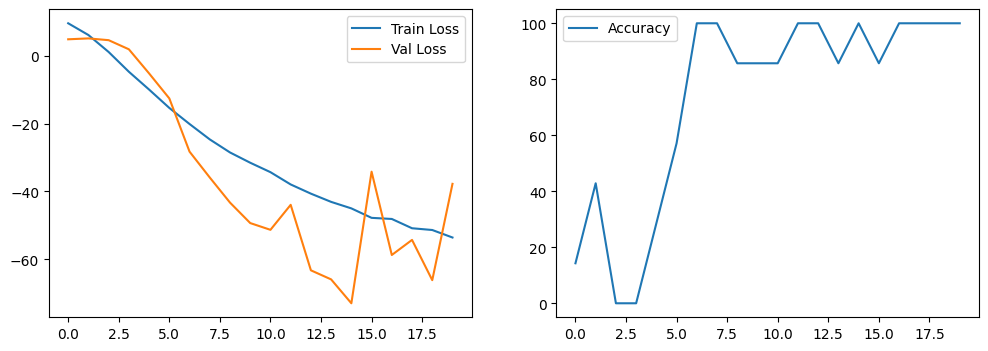

In [37]:
if __name__ == '__main__':
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  print(f"Using device: {device}")
  
  # Обучение
  model = train_model()
  
  # Сохранение модели
  torch.save(model.state_dict(), 'object_detector.pth')
  
  # Визуализация результатов
  # visualize_predictions(model, device)

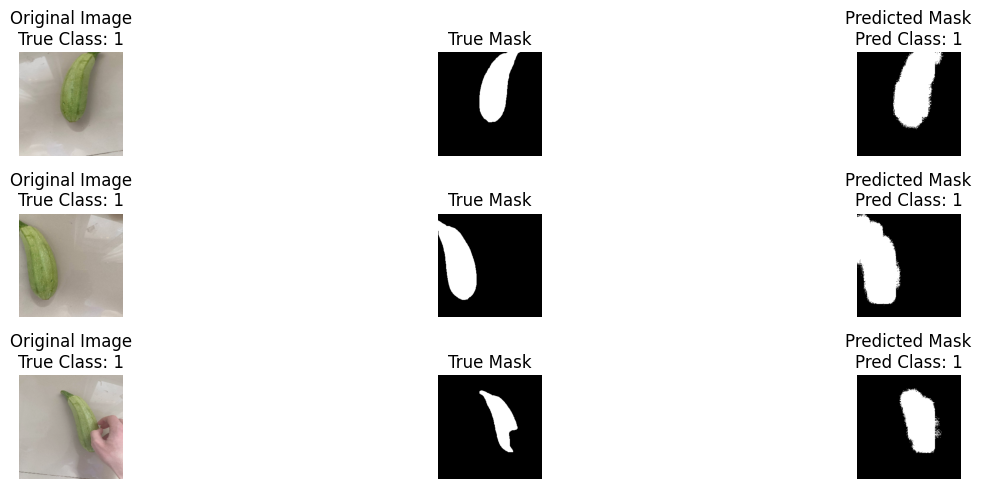

In [20]:
visualize_predictions(model, device)

In [21]:
# from model import DualTaskModel  # Импортируйте вашу модель
# from IPython import display

# class VideoProcessor:
#     def process_video(self):
#         class_names = ['Class0', 'Class1']
        
#         plt.figure(figsize=(10, 6))
        
#         while self.video.isOpened():
#             ret, frame = self.video.read()
#             if not ret:
#                 break
                
#             # Обработка кадра (ваш код)
            
#             # Визуализация через matplotlib
#             frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#             plt.imshow(frame_rgb)
#             plt.axis('off')
#             plt.title(f'Class: {class_names[class_id]} | Confidence: {confidence:.2f}')
#             display.clear_output(wait=True)  # Очистка предыдущего кадра
#             display.display(plt.gcf())  # Обновление отображения
            
#             # Сохранение в файл
#             self.writer.write(frame)
            
#         plt.close()  # Закрыть фигуру после обработки
#         self.video.release()
#         self.writer.release()


In [ ]:
class VideoProcessor:
    def __init__(self, model_path, video_path, output_path):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = model #self.load_model(model_path)
        self.video = cv2.VideoCapture(video_path)
        self.writer = self.setup_video_writer(output_path)
        
    def load_model(self, model_path):
        model = DualTaskModel(num_classes=3).to(self.device)
        model.load_state_dict(torch.load(model_path, map_location=self.device))
        model.eval()
        return model
    
    def setup_video_writer(self, output_path):
        fps = int(self.video.get(cv2.CAP_PROP_FPS))
        width = int(self.video.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(self.video.get(cv2.CAP_PROP_FRAME_HEIGHT))
        return cv2.VideoWriter(
            output_path,
            cv2.VideoWriter_fourcc(*'mp4v'),
            fps,
            (width, height)
        )
    
    def preprocess_frame(self, frame):
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        resized = cv2.resize(frame_rgb, (256, 256))
        tensor = torch.tensor(resized / 255.0).permute(2, 0, 1).float()
        return tensor.unsqueeze(0).to(self.device)
    
    def postprocess_mask(self, mask, original_size):
        mask = (torch.sigmoid(mask) > 0.5).cpu().numpy().squeeze()
        mask = cv2.resize(mask.astype(np.uint8), 
                         (original_size[1], original_size[0]))
        return mask
    
    def find_bounding_box(self, mask):
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            largest = max(contours, key=cv2.contourArea)
            x,y,w,h = cv2.boundingRect(largest)
            return (x, y, x+w, y+h)
        return None
    
    def process_video(self):
        class_names = ['Class0', 'Class1', 'Class2']  # Замените на ваши классы
        
        while self.video.isOpened():
            ret, frame = self.video.read()
            if not ret:
                break
                
            # Обработка кадра
            input_tensor = self.preprocess_frame(frame)
            
            with torch.no_grad():
                seg_out, cls_out = self.model(input_tensor)
            
            # Постобработка
            mask = self.postprocess_mask(seg_out, frame.shape[:2])
            bbox = self.find_bounding_box(mask)
            class_id = torch.argmax(cls_out).item()
            confidence = torch.max(torch.softmax(cls_out, dim=1)).item()
            
            # Визуализация
            if bbox and confidence > 0.98:
                x1, y1, x2, y2 = bbox
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0,255,0), 2)
                cv2.putText(frame, 
                           f"{class_names[class_id]} ({confidence:.2f})",
                           (x1, y1-10), 
                           cv2.FONT_HERSHEY_SIMPLEX, 
                           0.7, (0,255,0), 2)
            
            # Сохранение и отображение
            self.writer.write(frame)
            cv2.imshow('Result', frame)
            if cv2.waitKey(1) == 27:
                break
                
        self.video.release()
        self.writer.release()
        # cv2.destroyAllWindows()

In [48]:
# Использование
processor = VideoProcessor(
    model_path='object_detector.pth',
    video_path='t-0.mp4',
    output_path='output_video.mp4'
)
processor.process_video()

error: OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:1295: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvDestroyAllWindows'


In [28]:
class VideoTester:
    def __init__(self, model_path, video_path, output_size=(640, 480), max_frames=100):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = self.load_model(model_path)
        self.video = cv2.VideoCapture(video_path)
        self.output_size = output_size
        self.max_frames = max_frames
        self.class_names = ['Class0', 'Class1', 'Class2']  # Замените на свои классы
        
    def load_model(self, model_path):
        model = DualTaskModel(num_classes=3)
        model.load_state_dict(torch.load(model_path, map_location=self.device))
        model.eval()
        return model.to(self.device)
    
    def preprocess_frame(self, frame):
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        resized = cv2.resize(frame, (256, 256))
        tensor = torch.tensor(resized / 255.0).permute(2, 0, 1).float()
        return tensor.unsqueeze(0).to(self.device)
    
    def process_video(self):
        plt.figure(figsize=(10, 6))
        frame_count = 0
        
        while self.video.isOpened() and frame_count < self.max_frames:
            ret, frame = self.video.read()
            if not ret:
                break
                
            # Обработка кадра
            input_tensor = self.preprocess_frame(frame)
            
            with torch.no_grad():
                seg_out, cls_out = self.model(input_tensor)
            
            # Постобработка
            mask = (torch.sigmoid(seg_out) > 0.5).cpu().squeeze().numpy()
            mask = cv2.resize(mask.astype(np.uint8), 
                            (frame.shape[1], frame.shape[0]))
            
            # Поиск контуров
            contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            class_id = torch.argmax(cls_out).item()
            confidence = torch.max(torch.softmax(cls_out, dim=1)).item()
            
            # Отрисовка результатов
            result_frame = cv2.resize(frame, self.output_size)
            if len(contours) > 0 and confidence > 0.98:
                largest = max(contours, key=cv2.contourArea)
                x,y,w,h = cv2.boundingRect(largest)
                
                # Масштабирование координат
                scale_x = self.output_size[0] / frame.shape[1]
                scale_y = self.output_size[1] / frame.shape[0]
                x1, y1 = int(x*scale_x), int(y*scale_y)
                x2, y2 = int((x+w)*scale_x), int((y+h)*scale_y)
                
                cv2.rectangle(result_frame, (x1,y1), (x2,y2), (0,255,0), 2)
                cv2.putText(result_frame, 
                           f"{self.class_names[class_id]} ({confidence:.2f})",
                           (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2)
            
            # Отображение в Jupyter
            plt.imshow(cv2.cvtColor(result_frame, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.title(f'Processed Frame {frame_count}')
            display.clear_output(wait=True)
            display.display(plt.gcf())
            
            frame_count += 1
            
        self.video.release()
        plt.close()

# %%
if __name__ == '__main__':
    # Пример использования
    tester = VideoTester(
        model_path='object_detector.pth',
        video_path='t-0.mp4',  # Путь к вашему видео
        output_size=(640, 480),
        max_frames=50  # Обработать первые 50 кадров
    )
    tester.process_video()

Unexpected keys (bn2.bias, bn2.num_batches_tracked, bn2.running_mean, bn2.running_var, bn2.weight, classifier.bias, classifier.weight, conv_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.


In [29]:
class DualTaskModel(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        
        self.encoder = timm.create_model(
            'efficientnet_b0', 
            pretrained=True,
            features_only=True,
            out_indices=(4,)
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(320, 256, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 1, kernel_size=1)
        )

        self.cls_head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(320, num_classes)
        )
    def forward(self, x):
        features = self.encoder(x)[0]
        seg_out = self.decoder(features)
        seg_out = F.interpolate(seg_out, scale_factor=4, mode='bilinear')  # Фикс размерности
        cls_out = self.cls_head(features)
        return seg_out, cls_out

In [30]:
def train_model():
    BATCH_SIZE = 8
    EPOCHS = 20
    LR = 1e-4

    train_dataset = ObjectDataset('dataset', 'train')
    val_dataset = ObjectDataset('dataset', 'val')
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
    
    model = DualTaskModel(num_classes=3).to(device)
    optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=1e-5)  # Добавлена регуляризация
    
    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0
        
        for images, masks, labels in tqdm(train_loader):
            images = images.to(device)
            masks = masks.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            seg_out, cls_out = model(images)
            
            # Фикс: проверка размерностей
            seg_loss = nn.functional.interpolate.binary_cross_entropy_with_logits(
                seg_out, 
                nn.functional.interpolate.interpolate(masks, seg_out.shape[2:], mode='bilinear')  # Адаптация размеров
            )
            
            cls_loss = F.cross_entropy(cls_out, labels)
            loss = 0.7*seg_loss + 0.3*cls_loss
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()

In [31]:
class VideoProcessor:
    def process_video(self):
        plt.figure(figsize=(10, 6))
        
        while self.video.isOpened():
            ret, frame = self.video.read()
            if not ret:
                break
            
            # Обработка кадра
            ...
            
            # Визуализация через matplotlib
            plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            display.clear_output(wait=True)
            display.display(plt.gcf())
            
        plt.close()
        self.video.release()